In [4]:
import torch
from sentence_transformers import SentenceTransformer
from model import SimpleContrastiveNetwork, ContrastiveLoss
from dataset import ContrastiveDataset
from torch.utils.data import DataLoader

model_name = 'best_models/best_cl_transform-gsm8k_cl_trans_para0_47_autosplit-b16-e50-lr0.001-lt0.3.pth'
batch_size = 16
loss_temp = 0.3
dataset_csv = 'gsm8k_cl_trans_para0_47_autosplit.csv'
split = 'val'

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SimpleContrastiveNetwork().to(device)
model.load_state_dict(torch.load(model_name))
model.eval()

Val Original Loss: 1.473255, Val Transformed Loss: 0.373384


In [ ]:
# COMPARE ORIGINAL EMBEDDING LOSS TO TRANSFORMED EMBEDDINGS
sent_transformer = SentenceTransformer('all-MiniLM-L6-v2')
criterion = ContrastiveLoss(temperature=0.3, loss_type='BCE')

the_dataset = ContrastiveDataset(csv_path=dataset_csv, sent_transformer=sent_transformer, split=split)
the_loader = DataLoader(the_dataset, batch_size=32, shuffle=True)

total_original_loss = 0
total_transformed_loss = 0

for anchor_emb, positive_emb, negative_emb in the_loader:
    anchor_in = anchor_emb.to(device)
    positives_in = positive_emb.to(device)
    negatives_in = negative_emb.to(device)

    with torch.no_grad():
        anchor_out = model(anchor_in)
        positives_out = model(positives_in)
        negatives_out = model(negatives_in)
    combined_in = torch.cat((positives_in, negatives_in), dim=0)
    combined_out = torch.cat((positives_out, negatives_out), dim=0)

    original_loss = criterion(anchor_in.repeat(2, 1), combined_in)
    transformed_loss = criterion(anchor_out.repeat(2, 1), combined_out)
    
    total_original_loss += original_loss.item()
    total_transformed_loss += transformed_loss.item()

avg_original_loss = total_original_loss / len(the_loader)
avg_transformed_loss = total_transformed_loss / len(the_loader)

print(f"{split.title()} Original Loss: {original_loss.item():.6f}, {split.title()} Transformed Loss: {transformed_loss.item():.6f}")

ANCHOR   (Sentence 1):  Finally, let's calculate the time it takes for Mohammad to bike the distance for his weekend bike ride. He bikes 200 miles at a speed of 25 mph, so the time it takes for him to bike the distance is 200 miles / 25 mph = 8 hours.
POSITIVE (Sentence 2):  Let's work out how long it takes for Mohammad to complete his weekend cycling trip. He covers a distance of 200 miles at a pace of 25 mph, which means the duration of his bike ride is 200 miles / 25 mph = 8 hours.
NEGATIVE (Sentence 3):  First, let's find out how many pages Mohammad can read in 1 minute. We can do this by dividing the number of pages he can read in 20 minutes by 20. So, 8 pages / 20 minutes = 0.4 pages/minute.  ,
NEGATIVE (Sentence 4):  Therefore, the total sales for this month would be $960 + $240 = $1200.
NEGATIVE (Sentence 5):  Step 8: Solve the equation to find the value of x. $15 = $15 + $60 + $7x - $95 $15 = $75 + $7x - $95 $15 = $7x - $20 $35 = $7x x = $35 / $7 x = 5


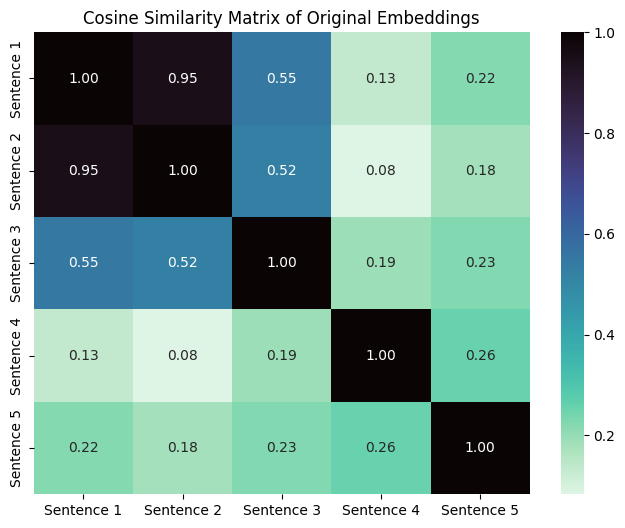

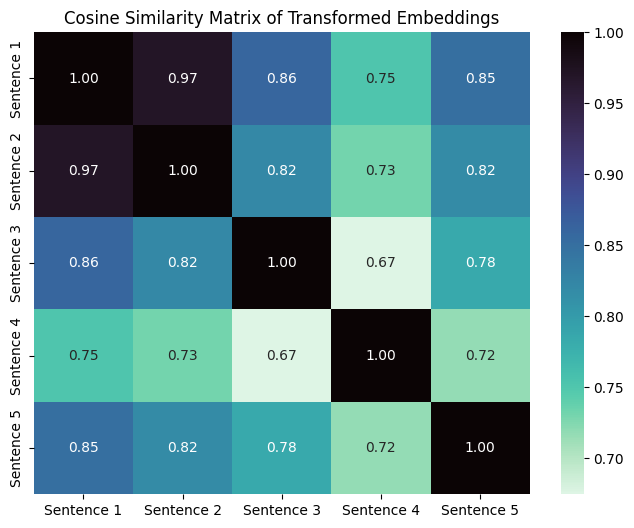

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import ast

df = pd.read_csv('data/gsm8k_cl_trans_para0_47_autosplit.csv')
df['Positive'] = df['Positive'].apply(ast.literal_eval)
df['Negative'] = df['Negative'].apply(ast.literal_eval)

rand_df = df.sample(1, random_state=33)

positiveEmb, negativeEmb = rand_df['Positive'].tolist()[0][:3], rand_df['Negative'].tolist()[0][:3]
print(f'ANCHOR   (Sentence 1): ', rand_df['Reasoning Trace'].tolist()[0])
print(f'POSITIVE (Sentence 2): ', positiveEmb[0])
# print(len(positiveEmb))
for i, negemb in enumerate(negativeEmb): 
    print(f'NEGATIVE (Sentence {i + 3}): ', negemb)
# print(len(negativeEmb))

new_sentences = rand_df['Reasoning Trace'].tolist() + rand_df['Positive'].tolist()[0][:3] + rand_df['Negative'].tolist()[0][:3]
new_sentences

def plot_sim_matrix(new_sentences):
    sent_transformer = SentenceTransformer('all-MiniLM-L6-v2')
    original_embeddings = sent_transformer.encode(new_sentences, batch_size=32)
    original_embeddings_tensor = torch.tensor(original_embeddings, dtype=torch.float).to(device)

    model.eval()

    with torch.no_grad():
        transformed_embeddings = model(original_embeddings_tensor).cpu().numpy()

    original_cos_sim_matrix = cosine_similarity(original_embeddings)
    # print("Original Embedding Cosine Similarity Matrix:\n", original_cos_sim_matrix)
    transformed_cos_sim_matrix = cosine_similarity(transformed_embeddings)
    # print("Transformed Embedding Cosine Similarity Matrix:\n", transformed_cos_sim_matrix)


    plt.figure(figsize=(8, 6))
    sns.heatmap(original_cos_sim_matrix, annot=True, cmap="mako_r", fmt=".2f",
                xticklabels=[f"Sentence {i+1}" for i in range(len(new_sentences))],
                yticklabels=[f"Sentence {i+1}" for i in range(len(new_sentences))])
    plt.title('Cosine Similarity Matrix of Original Embeddings')
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(transformed_cos_sim_matrix, annot=True, cmap="mako_r", fmt=".2f",
                xticklabels=[f"Sentence {i+1}" for i in range(len(new_sentences))],
                yticklabels=[f"Sentence {i+1}" for i in range(len(new_sentences))])
    plt.title('Cosine Similarity Matrix of Transformed Embeddings')
    plt.show()

plot_sim_matrix(new_sentences)

ANCHOR   (Sentence 1):  First, let's calculate how many clips Mohammad sold in May. We know that he sold half as many clips in May as he did in April. To find this out, we need to divide the number of clips sold in April by 2. 48 / 2 = 24 So, Mohammad sold 24 clips in May.
POSITIVE (Sentence 2):  In May, the number of water bottles sold was quadruple that of April's. With April's sales at 40, May saw 40 * 4 = 160 bottles sold.
NEGATIVE (Sentence 3):  Combining April and May's figures gives us a total: 40 bottles from April plus 160 from May equals 200 bottles.
NEGATIVE (Sentence 4):  Therefore, Mohammad sold a total of 72 clips in April and May.
NEGATIVE (Sentence 5):  Step 8: Solve the equation to find the value of x. $15 = $15 + $60 + $7x - $95 $15 = $75 + $7x - $95 $15 = $7x - $20 $35 = $7x x = $35 / $7 x = 5


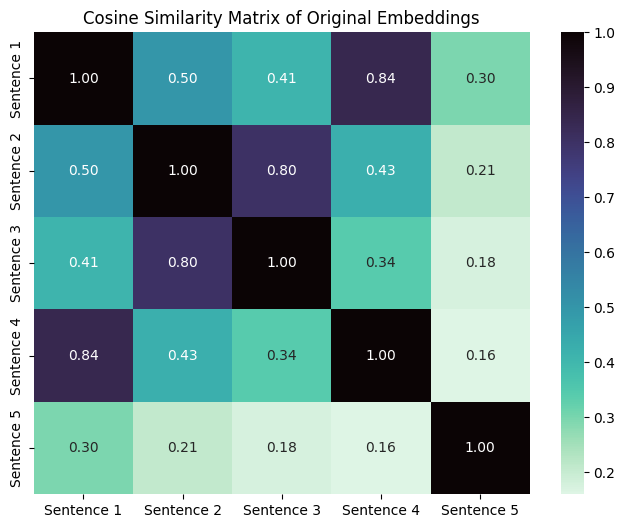

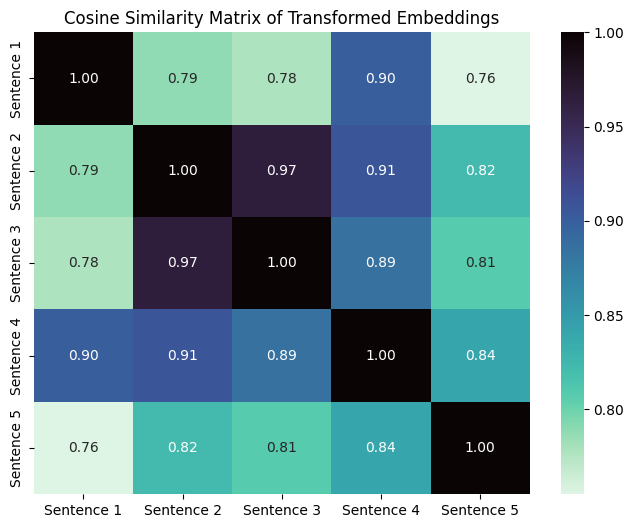

In [15]:
anchor_ex = "First, let's calculate how many clips Mohammad sold in May. We know that he sold half as many clips in May as he did in April. To find this out, we need to divide the number of clips sold in April by 2. 48 / 2 = 24 So, Mohammad sold 24 clips in May."
positive_ex = "In May, the number of water bottles sold was quadruple that of April's. With April's sales at 40, May saw 40 * 4 = 160 bottles sold."
negative_exs = [
    "Combining April and May's figures gives us a total: 40 bottles from April plus 160 from May equals 200 bottles.",
    "Therefore, Mohammad sold a total of 72 clips in April and May.",
    "Step 8: Solve the equation to find the value of x. $15 = $15 + $60 + $7x - $95 $15 = $75 + $7x - $95 $15 = $7x - $20 $35 = $7x x = $35 / $7 x = 5"
]

print(f'ANCHOR   (Sentence 1): ', anchor_ex)
print(f'POSITIVE (Sentence 2): ', positive_ex)
for i, negemb in enumerate(negative_exs): 
    print(f'NEGATIVE (Sentence {i + 3}): ', negemb)

new_ex_sentences = [anchor_ex] + [positive_ex] + negative_exs
plot_sim_matrix(new_ex_sentences)